In [1]:
import os,sys
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
from numpy import linalg
import skimage.util
import scipy.ndimage.filters
import scipy.misc
import scipy.io
from scipy import stats

import utils

In [2]:
from keras.models import load_model
autoencoder = load_model('my_models/cdA_jpeg.h5')

Using TensorFlow backend.


Fontconfig warning: ignoring UTF-8: not a valid region tag



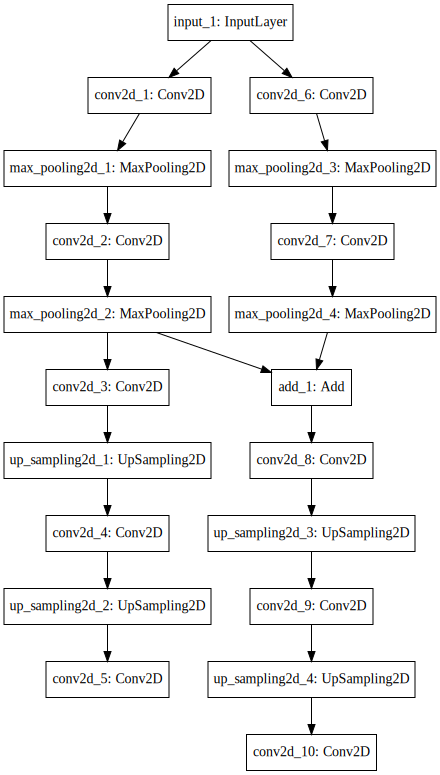

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))

In [6]:
################## Model Flow Diagram ####################
from keras.utils import plot_model
plot_model(autoencoder, to_file='my_models/cdA_jpeg_model.png')

Fontconfig warning: ignoring UTF-8: not a valid region tag



In [4]:
from keras import backend as K
layer_dict = dict([(layer.name, layer) for layer in autoencoder.layers])
get_dist_hidden = K.function([layer_dict['input_1'].input],
                             [layer_dict['max_pooling2d_4'].output])

In [5]:
os.mkdir("results/jpeg")
datadir = '/data2/rajeev/dA_IQA/data/LIVE/jpeg/'

OSError: [Errno 17] File exists: 'results/jpeg'

In [6]:
# Collecting all the AWGN files
datadir = '/data2/rajeev/dA_IQA/data/LIVE/jpeg/'
files = [f for f in listdir(datadir) if isfile(join(datadir, f))]

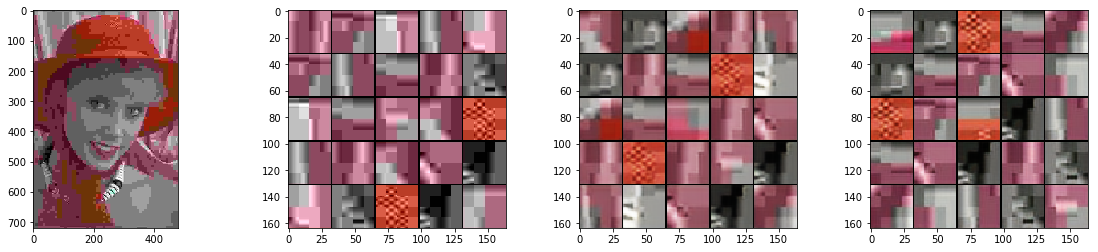

In [8]:
# img 26, 89, 1, 138
f = datadir + 'img' + str(138) + '.bmp'
I = mpimg.imread(f)
P = utils.getPatchesDict(I, psize=[32, 32], noPatches=4000, entropy_th=3.0, stride=2)
P.shape
visP = utils.visualize(P, [32, 32], [1, 1], [5, 5], 1)
decoded_imgs = autoencoder.predict([P])
vis_clean = utils.visualize(decoded_imgs[0], [32, 32], [1, 1], [5, 5], 1)
vis_dist = utils.visualize(decoded_imgs[1], [32, 32], [1, 1], [5, 5], 1)
plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.imshow(I)
plt.subplot(1, 4, 2)
plt.imshow(visP)
plt.subplot(1, 4, 3)
plt.imshow(vis_clean)
plt.subplot(1, 4, 4)
plt.imshow(vis_dist)
plt.show()

In [9]:
dist_mats = get_dist_hidden([P])[0]
print dist_mats.shape
scores = np.linalg.norm(dist_mats.reshape((dist_mats.shape[0], np.prod(dist_mats.shape[1:]))), axis=1)
print np.mean(scores)

(31, 8, 8, 32)
15.5526


In [10]:
######## Score Calculation ########
scores = np.zeros(233)
for i in range(233):
    f = datadir + 'img' + str(i+1) + '.bmp'
    I = mpimg.imread(f)
    P = utils.getPatchesDict(I, psize=[32, 32], noPatches=4000, entropy_th=3.0, stride=2)
    dist_hidden = get_dist_hidden([P])[0]
    distortion = dist_hidden.reshape((dist_hidden.shape[0], np.prod(dist_hidden.shape[1:])))
    score = np.mean(np.linalg.norm(distortion, axis=1))
    scores[i] = score
    
    if (i+1)%30 == 0:
        string = str(i+1) + '/233' + 'images done!'
        print string
    elif i + 1 == 233:
        string = str(i+1) + '/233' + 'images done!'
        print string

scipy.io.savemat('results/jpeg/QualityScores.mat', mdict = {'scores': scores})

30/233images done!
60/233images done!
90/233images done!
120/233images done!
150/233images done!
180/233images done!
210/233images done!
233/233images done!


In [11]:
####### Correlation Calculation ######
data = scipy.io.loadmat('../../data/LIVE/dmos.mat')
dmos = data["dmos"]
orgs = data["orgs"]
# JPEG values
dmos = dmos[:, 227 : 460]
orgs = orgs[:, 227 : 460]

data = scipy.io.loadmat('results/jpeg/QualityScores.mat')
scores = data["scores"]

distIndcs = np.where(orgs == 0)[1]
dmos = dmos[:, distIndcs]
scores = scores[:, distIndcs]

rho, pval = scipy.stats.spearmanr(scores[0, :], dmos[0, :])
scipy.io.savemat('results/jpeg/CorrScores.mat', mdict = {'SROCC': rho})

string = 'Correlation Score = ' + str(rho)
print string

Correlation Score = 0.19594017406


In [36]:
dmos.shape, scores.shape

((1, 175), (1, 175))

In [15]:
plt.switch_backend('agg')
plt.figure(figsize=(10, 10))
plt.scatter(dmos, scores)
plt.xlabel('DMOS')
plt.ylabel('scores')
plt.show()
plt.savefig('results/jpeg/scatter.png')